<a href="https://colab.research.google.com/github/dafses/Machine-Learning-Projects/blob/main/suit_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import** **Dataset**

> memasukan dataset dari google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/machine learning/

/content/drive/My Drive/machine learning


In [ ]:
!ls "/content/drive/My Drive/machine learning/"

paper  rock  scissors


#**Preprocessing Data**

> memasukan library yang dibutuhkan

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

import os
from skimage.feature import hog
from skimage import io, color, exposure
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from random import randint
from skimage import transform


> langkah selanjutnya adalah Load Dataset,  Ekstraksi Fitur HOG, Augmentasi Gambar, Normalisasi Fitur dan juga pembagian Dataset menjadi Data Latih dan Data Uji

penjelasan :


*   pada bagian Kode ini mesin akan membaca dataset dari tiga folder yang berbeda di Google Drive.

*   Setiap gambar diubah ke dalam skala keabuan dan kemudian fitur HOG diekstraksi menggunakan fungsi hog dari modul **skimage.feature**.

*   Setelah itu, dataset dibagi menjadi data latih dan data uji dengan rasio 80:20 menggunakan fungsi **train_test_split** dari **scikit-learn**.
*   Terakhir, kode menampilkan jumlah total data, jumlah data latih, dan jumlah data uji yang sudah dibagi.

penjelasan tambahan :

*   Fungsi **augment_image** ditambahkan untuk melakukan augmentasi pada gambar. Gambar asli, gambar yang di-flip secara horizontal, serta gambar yang di-rotasi 90 derajat searah dan berlawanan jarum jam ditambahkan sebagai variasi. proses ini dilakukan di dalam loop yang sama dengan proses ekstraksi fitur HOG.
*   Setelah pembagian dataset menjadi data latih dan data uji, kita melakukan normalisasi pada fitur menggunakan **StandardScaler** dari **sklearn.preprocessing**.

*   **fit_transform** diterapkan pada data latih untuk menghitung mean dan standar deviasi, lalu menerapkan transformasi. transform diterapkan pada data uji menggunakan parameter yang sudah dihitung dari data latih.









In [ ]:
dataset_path = '/content/drive/My Drive/machine learning/'

X = []
y = []
paper_images = []  # List untuk nyimpan gambar kertas
image_paths = []   # List untuk nyimpan beberapa gambar


def augment_image(image):
    augmented_images = []
    augmented_images.append(image)
    augmented_images.append(cv2.flip(image, 1))  # Horizontal flip
    augmented_images.append(cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE))  # Rotate 90 degrees
    augmented_images.append(cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE))  # Rotate -90 degrees
    return augmented_images




# Load dan process images
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if folder == 'paper' and len(paper_images) < 10:
          paper_images.append(img)  # simpen 10 gambar kertas buat ditampilin

        # Store image path for displaying later
        image_paths.append((img_path, folder))

        # Augmentasi
        augmented_images = augment_image(img)
        for aug_img in augmented_images:
          hog_features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L2-Hys")
          X.append(hog_features)
          y.append(folder)

# Convert ke numpy arrays
X = np.array(X)
y = np.array(y)

print("Total jumlah data:", len(X))

#Pisahkan data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Jumlah data latih:", len(X_train))
print("Jumlah data uji:", len(X_test))

# Normalisasi
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Total jumlah data: 8752
Jumlah data latih: 7001
Jumlah data uji: 1751


> **Manampilkan Contoh Data Yang Ada**

1. Contoh Data Kertas

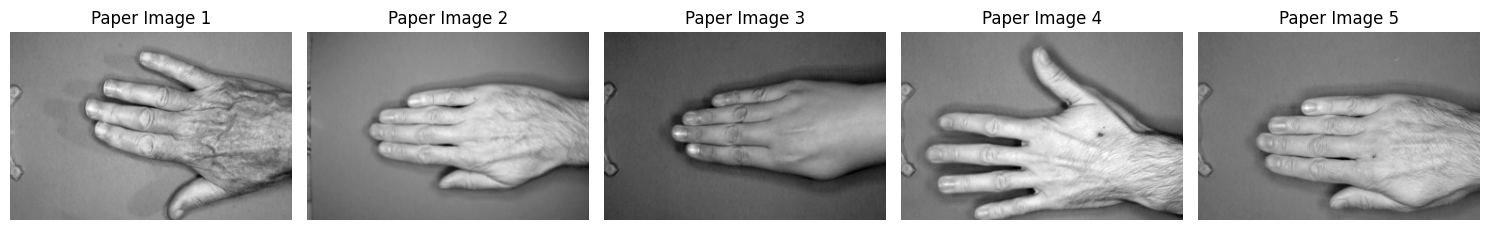

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    plt.imshow(paper_images[i], cmap='gray')
    plt.title('Paper Image {}'.format(i + 1))
    plt.axis('off')
plt.tight_layout()
plt.show()


2. Contoh Data Train (Latih)

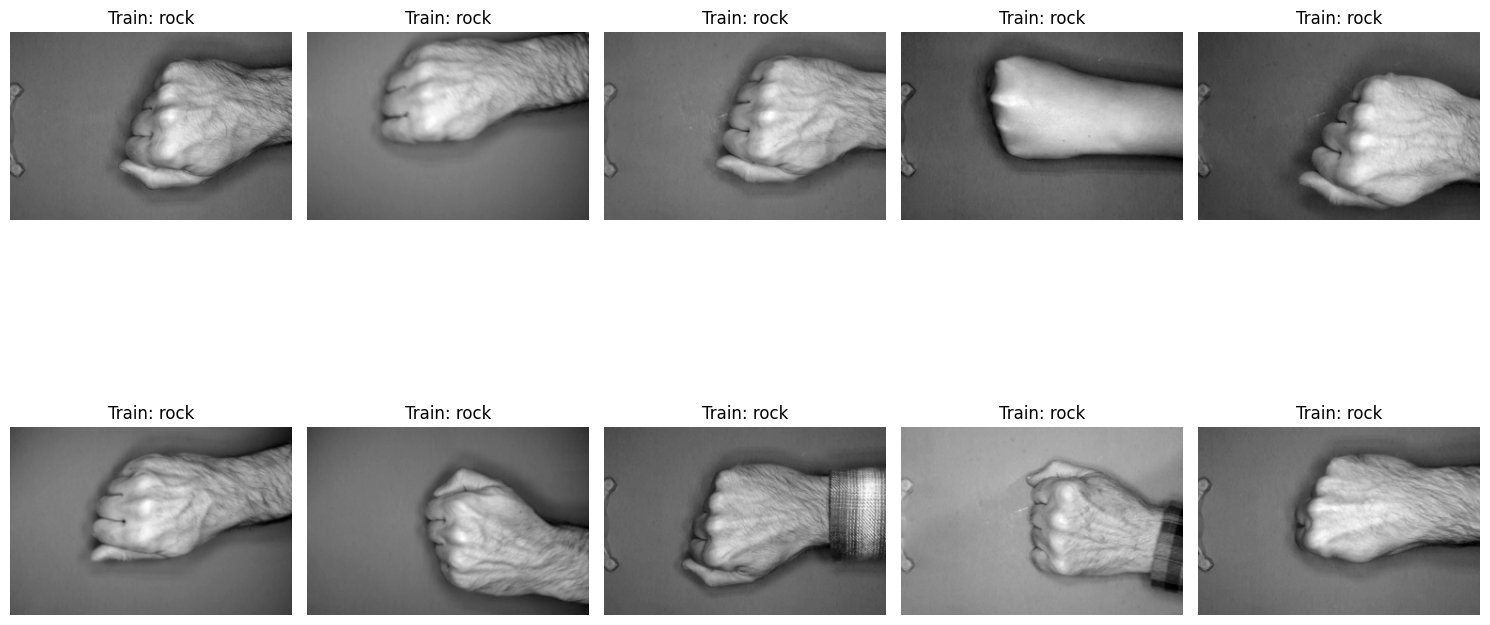

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(10):
    img_path, label = image_paths[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Train: {}'.format(label))
    plt.axis('off')
plt.tight_layout()
plt.show()


3 . Contoh Data Test(Uji)

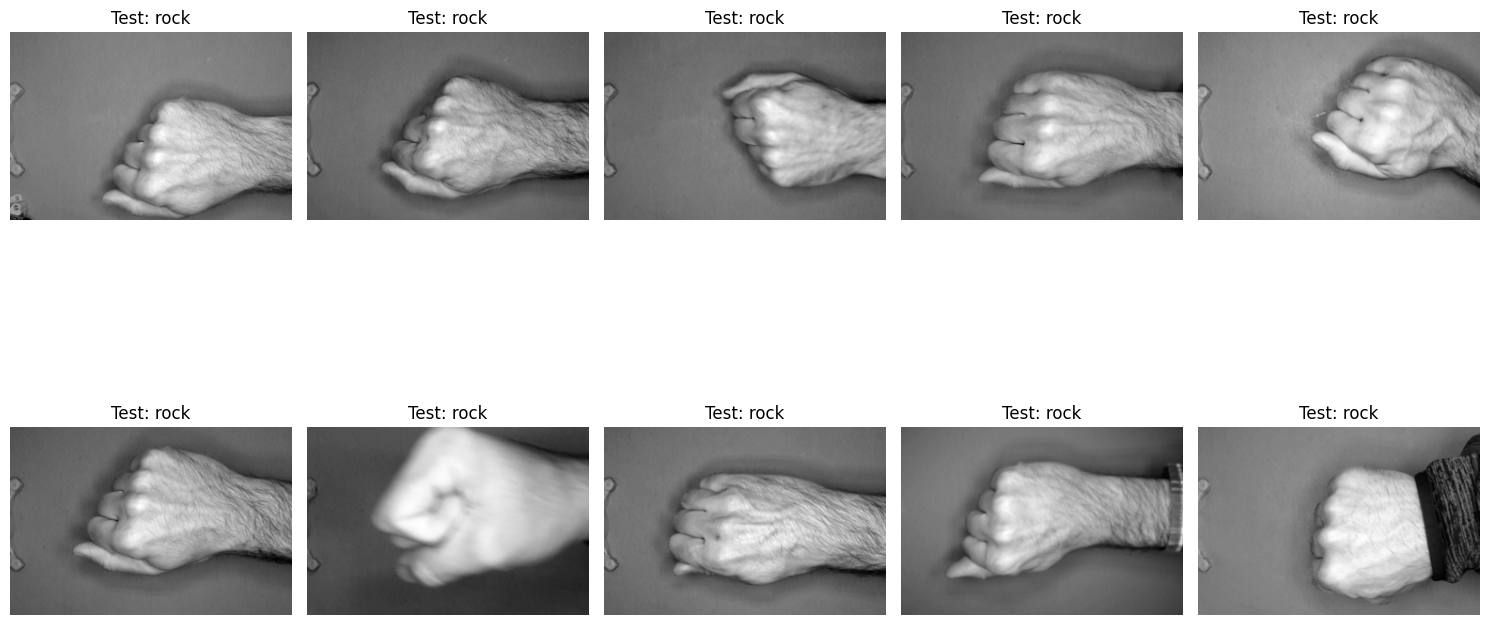

In [ ]:
test_image_paths = image_paths[-len(X_test):]
plt.figure(figsize=(15, 10))
for i in range(10):
    img_path, label = test_image_paths[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.title('Test: {}'.format(label))
    plt.axis('off')
plt.tight_layout()
plt.show()


# **Modeling**

> Proses **Training** dan **Prediksi**

**1. GaussianNB()**
*   **GaussianNB** adalah kelas dari sklearn.naive_bayes yang mengimplementasikan algoritma Gaussian Naive Bayes. Ini adalah salah satu varian dari Naive Bayes yang mengasumsikan bahwa fitur-fitur kontinu mengikuti distribusi Gaussian (normal).

**2. model.fit(X_train, y_train):**
*   **fit** adalah metode yang digunakan untuk melatih model pada data yang diberikan.
*   **X_train** adalah array fitur dari data latih, dan **y_train** adalah array label atau target dari data latih.
*   **Model** akan mempelajari hubungan antara fitur (dalam bentuk HOG features) dan label (kategori gambar: 'paper', 'rock', 'scissors').

**3. model.predict(X_test):**
*   **predict** adalah metode yang digunakan untuk membuat prediksi berdasarkan model yang sudah dilatih.
*   **X_test** adalah array fitur dari data uji.
*   Metode ini mengembalikan prediksi label untuk setiap sampel dalam data uji, yang disimpan dalam y_pred.







In [ ]:
model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


# **Postprocessing Data**

Akurasi: 0.8537978298115363
Laporan Klasifikasi:
               precision    recall  f1-score   support

       paper       0.86      0.86      0.86       590
        rock       0.80      0.92      0.85       574
    scissors       0.92      0.79      0.85       587

    accuracy                           0.85      1751
   macro avg       0.86      0.85      0.85      1751
weighted avg       0.86      0.85      0.85      1751

Matriks Kebingungan:
 [[506  61  23]
 [ 33 526  15]
 [ 50  74 463]]


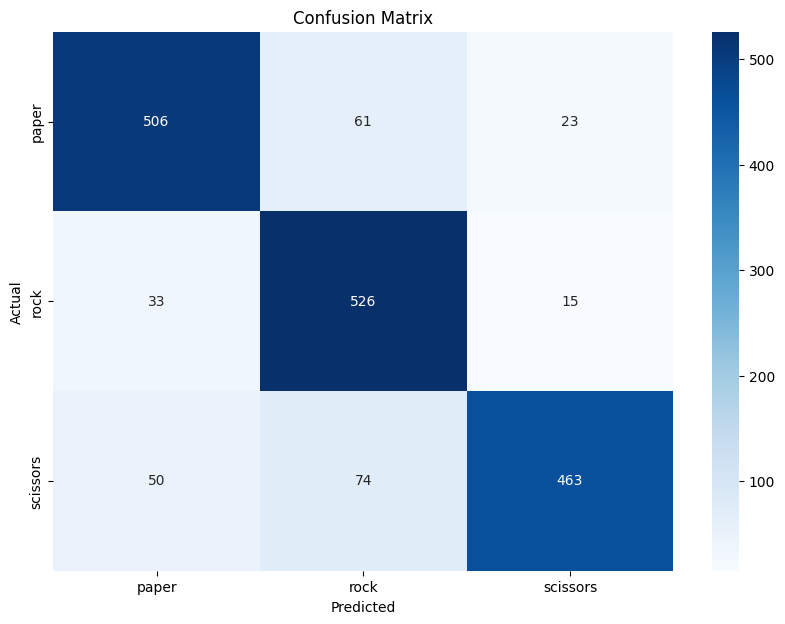

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Akurasi:", accuracy)

classification_report_str = classification_report(y_test, y_pred)
print("Laporan Klasifikasi:\n", classification_report_str)

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriks Kebingungan:\n", conf_matrix)

plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


> **Evaluasi Model**

Evaluasi model dilakukan untuk menguji dan memahami seberapa baik model kita dalam mengklasifikasikan data baru, dalam program ini data baru yang diberikan adalah data test yang telah kita bagi sebelumnya.

**1.Akurasi**
*   **accuracy_score** adalah fungsi dari sklearn.metrics yang menghitung rasio prediksi yang benar (label prediksi sesuai dengan label aktual) terhadap total jumlah prediksi.
*   **y_test** dan **y_pred** adalah array label sebenarnya dan prediksi dari data uji.
*   Nilai akurasi memberikan gambaran umum tentang performa model dalam persentase.


**2.Laporan Klarifikasi**
*   **classification_report** adalah fungsi dari sklearn.metrics yang menghasilkan laporan teks menunjukkan metrik utama untuk setiap kelas.
Metrik yang termasuk adalah precision, recall, F1-score, dan support.
*   **Precision:** Proporsi prediksi positif yang benar (True Positives / (True Positives + False Positives)).
*   **Recall:** Proporsi kejadian sebenarnya yang teridentifikasi dengan benar (True Positives / (True Positives + False Negatives)).
*   **F1-score:** Harmonic mean dari precision dan recall.
*   **Support:** Jumlah kejadian sebenarnya dari setiap kelas dalam dataset uji.

**3. Matriks Kebingungan (Confusion Matrix)**
*  Matriks kebingungan adalah alat yang digunakan untuk mengevaluasi kinerja algoritma klasifikasi.
*  Adapun secara pengertian **Matriks kebingungan (confusion matrix)** dinamakan demikian karena matriks ini menunjukkan bagaimana sebuah model klasifikasi dapat "bingung" atau salah dalam mengklasifikasikan sampel-sampel yang ada.
* **Menghitung Matriks Kebingungan**

    **confusion_matrix** adalah fungsi dari sklearn.metrics yang digunakan untuk menghitung matriks kebingungan.
    Fungsi ini mengembalikan matriks kebingungan sebagai array dua dimensi. hasilnya akan ditampilkan dalam kode : **print("Matriks Kebingungan:\n", conf_matrix)**
* **Visualisasi Matriks Kebingungan**

    **plt.figure(figsize=(10,7)):** Membuat figure baru dengan ukuran yang ditentukan.

    **sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y)):** Menggunakan seaborn untuk memvisualisasikan matriks kebingungan. Anotasi (angka) dalam setiap sel akan ditampilkan, dengan format angka desimal.

    **plt.ylabel('Actual'):** Memberi label pada sumbu Y sebagai "Actual".

    **plt.xlabel('Predicted'):** Memberi label pada sumbu X sebagai "Predicted".
    
    **plt.title('Confusion Matrix'):** Menambahkan judul pada plot.
    
    **plt.show():** Menampilkan plot.

